# General Setup

In [1]:
# !pip3 install numba==0.48.0 -q

In [2]:
# !pip install git+https://github.com/PyFstat/PyFstat@python37 -q

In [3]:
# import numba.core.ir

In [4]:
# OS
import os
import sys
import glob
import pathlib
from pathlib import Path

# General DS
import matplotlib.pyplot as plt
import math
from math import floor, ceil
import numpy as np
from numpy.random import Generator, PCG64
import pandas as pd
import random
import seaborn as sns
from scipy import stats
from scipy.stats import uniform

# Algorithms
from sklearn.neighbors import KernelDensity
from sklearn.svm import SVC, NuSVC, LinearSVC

# Specific for competition
# import h5py
# import pyfstat
# from pyfstat.utils import get_sft_as_arrays

# Utils
import collections
from collections import Callable
from copy import copy
from datetime import datetime
import gc
from PIL import Image
import psutil
from time import time
from tqdm.notebook import tqdm
import types
import warnings

gc.enable()

ROOT_PATH = Path('/kaggle/input/g2net-detecting-continuous-gravitational-waves')
TRAIN_DATA_PATH = ROOT_PATH/'train'
TEST_DATA_PATH = ROOT_PATH/'test'
LABELS_PATH = ROOT_PATH/'train_labels.csv'
REAL_NOISE_PATH = Path('/kaggle/input/realistic-noise-256/data/realistic_noise/images')
REAL_SIGNAL_PATH = Path('/kaggle/input/g2net-pure-signal/pure_signal')
DATA_GENERATION_OUTPUT_PATH = Path('/kaggle/working/pyfstat_data_generation')
GENERATED_DATA_PATH = Path('/kaggle/input/generated-sfts/generated')
GENERATED_DATA_PATH_PNG = Path("/kaggle/input/g2-generated-pngs/")
COMPETITION_DATA_PNG_PATH = Path("/kaggle/input/g2-competition-pngs")
CLEAN_OUTPUT = True

DATA_GENERATION = False

seed = 42
rng = Generator(PCG64(seed))


def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

print(cpu_stats())

%matplotlib inline

memory GB:0.25


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


# Data exploration

In [5]:
def get_size(obj, seen=None, ret=False):
    """
    Recursively finds size of objects.
    Credit: https://goshippo.com/blog/measure-real-size-any-python-object/
    Args:
        obj: The object to find the size of.
        seen: A set of previously seen objects to avoid infinite recursion.
    Returns:
        The size of the object in bytes.
    """
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

def getsizeGB(item):
    print(f'Size of item is: {get_size(item)/1000000000} GB')
    
def get_obj_size(obj):
    marked = {id(obj)}
    obj_q = [obj]
    sz = 0

    while obj_q:
        sz += sum(map(sys.getsizeof, obj_q))

        # Lookup all the object referred to by the object in obj_q.
        # See: https://docs.python.org/3.7/library/gc.html#gc.get_referents
        all_refr = ((id(o), o) for o in gc.get_referents(*obj_q))

        # Filter object that are already marked.
        # Using dict notation will prevent repeated objects.
        new_refr = {o_id: o for o_id, o in all_refr if o_id not in marked and not isinstance(o, type)}

        # The new obj_q will be the ones that were not marked,
        # and we will update marked with their ids so we will
        # not traverse them again.
        obj_q = new_refr.values()
        marked.update(new_refr.keys())

    return sz

In [6]:
def _rectify_time(real, imag, ts, ref_ts, step):
    
    rect_real = np.zeros(shape=(real.shape[0], ref_ts.shape[0]))
    rect_imag = np.zeros(shape=(imag.shape[0], ref_ts.shape[0]))
    
    didx = 0 ## data index to keep track from where to search
    prop = 0
    
    reference_point = ref_ts[0]
    
    real_leftover = np.zeros(shape=(1, real.shape[0])) ## leftover is the frequence from the previous timestep to be added to the current one if the timesteps didn't align
    imag_leftover = np.zeros(shape=(1, imag.shape[0]))
    ## the proportion of how much the leftovers account for the next time step.
    leftover_prop = (ts[0] - ref_ts[0]) / step
            
    ## loop over the rectified reference time steps
    for i in range(len(ref_ts)):        
        c_ts = ref_ts[i] ## current timestep
        
        if ts[didx] < c_ts:
            continue
                           
        if i+1 == len(ref_ts):
            n_ts = c_ts + 2*step ## to make sure all the steps fall into the interval
        else:
            n_ts = ref_ts[i+1]
                        
        rect_real[:, i] = rect_real[:, i] + real_leftover * leftover_prop ## add the leftover from the previous step
        rect_imag[:, i] = rect_imag[:, i] + imag_leftover * leftover_prop
                
        total_prop = leftover_prop ## helper variable to check if the final proportions add up to 1
        ## search for all the timesteps that fall within the interval of the rectified reference timesteps      
                        
        if ts[didx] >= n_ts:
#             print(f'1: ts[didx] >= n_ts happened for {ts[didx]-reference_point}, {n_ts-reference_point}, iteration {i}, didx: {didx}')
            real_leftover = np.zeros(shape=(1, real.shape[0])) ## leftover is the frequence from the previous timestep to be added to the current one if the timesteps didn't align
            imag_leftover = np.zeros(shape=(1, imag.shape[0]))
            leftover_prop = 0
            continue
                
        for j in range(didx, len(ts)):
            
            if j+1==len(ts):
                break
            
            ## break this for loop if the timestep is equal or higher than the next rectified timestep
            ## this means that some rectified amplitudes will be 0 for timestep j (which is what we want)
            if ts[j] >= n_ts:
#                 print(f'2: ts[j] >= n_ts happened for {ts[j]-reference_point}, {n_ts-reference_point}, iteration {i},{j}, previous: {previous}')
                previous = False
                didx = j
                if ts[j] - ts[j-1] > 1800: ## we are assuming here that each observation is at max of duration 30 minutes (if the time difference is bigger, the observation stopped at t=1800)
                    leftover_prop = (ts[j-1]-n_ts + 1800) / step
                else:
                    leftover_prop = (ts[j]-n_ts) / step
                break
                
            ## check if the next time step falls within the interval of the rectified reference timestep.
            ## if yes, take the next retified reference time step as the end point, and set the leftover proportion for the next step
            ## else; take the next time step as the end point.
            if ts[j+1] >= n_ts:
#                 print(f"3: ts[j+1] >= n_ts happened for {ts[j+1]-reference_point}, {n_ts-reference_point}, iteration {i},{j}")
#                 previous = True
                prop = (n_ts - ts[j]) / step
                real_leftover = real[:, j]
                imag_leftover = imag[:, j]
            else:
#                 print(f"4: ts[j+1] >= n_ts DID NOT happen for {ts[j+1]-reference_point}, {n_ts-reference_point}, iteration {i},{j}")
                prop = (ts[j+1] - ts[j]) / step
#             print(f"it: {j} prop: {prop}")
            rect_real[:, i] = rect_real[:, i] + real[:,j]*prop
            rect_imag[:, i] = rect_imag[:, i] + imag[:,j]*prop
            
            
            
            total_prop += prop      
        
#         print(f"total prop: {total_prop}")
#         print(f"leftover prop: {leftover_prop}")
    return rect_real, rect_imag

def rectify_time(Hreal,
                 Himag,
                 Lreal,
                 Limag,
                 H_ts,
                 L_ts,
#                  amplitudes: dict, 
#                  timesteps: dict, 
                 step: int):
    
    t_0 = np.int32(min([np.min(H_ts), np.min(L_ts)]))

    t_end = np.int32(max([np.max(H_ts), np.max(L_ts)]))
    
    total_steps = np.int32(np.ceil(np.abs(t_end-t_0)/step))
    
    rectified_ts = np.arange(start=0, stop=total_steps*step+1, step=step, dtype=int)
    reference_ts = rectified_ts + t_0

#     rectified_L1_amp_real = np.zeros(shape=(L1_amp_real.shape[0], rectified_ts.shape[0]))
#     rectified_L1_amp_imag = np.zeros(shape=(L1_amp_imag.shape[0], rectified_ts.shape[0]))
    
    rectified_L1_amp_real, rectified_L1_amp_imag = _rectify_time(Lreal, 
                                                                 Limag,
#                                                                  rectified_L1_amp_real,
#                                                                  rectified_L1_amp_imag,
                                                                 L_ts,
                                                                 reference_ts,
                                                                 step)
    
    rectified_H1_amp_real, rectified_H1_amp_imag = _rectify_time(Hreal, 
                                                                 Himag,
#                                                                  rectified_H1_amp_real,
#                                                                  rectified_H1_amp_imag,
                                                                 H_ts,
                                                                 reference_ts,
                                                                 step)
    
    return {'Hreal': rectified_H1_amp_real, 'Himag': rectified_H1_amp_imag,
            'Lreal': rectified_L1_amp_real, 'Limag': rectified_L1_amp_imag}
    

In [7]:
def Normal(x):
    return x

def MaxPooling1D(x, axis=0):
    """
    Performs max pooling on the input data along the specified axis.
    Input:
        x: a numpy array
        axis: the axis along which to perform the pooling (defaults to 0)
    Output:
        a numpy array with the same shape as the input
    """
    r = np.zeros(shape=x.shape)
    r[np.argmax(x, axis=axis), np.argmax(np.identity(x.shape[1]), axis=axis)] = 1
    return r

def Normalize(x):
    """
    Normalizes the input data by rescaling it to a range between 0 and 1.
    Input:
        x: a numpy array
    Output:
        a numpy array with the same shape as the input
    """
    return (x - np.max(x))/(np.max(x) - np.min(x))

def Rescale(x):
    """
    Rescales the input data by dividing each element by the mean of the input array along the specified axis.
    Input:
        x: a numpy array
    Output:
        a numpy array with the same shape as the input
    """
    return x / (np.mean(x, axis=0) + 1e-10)

def CompressFrequencies(x, fun=np.max):
    """
    Compresses the frequencies in the input data by applying the specified function to pairs of elements in the array.
    Input:
        x: a numpy array
        fun: the function to apply to pairs of elements in the array (defaults to np.max)
    Output:
        a numpy array with the same shape as the input
    """
    odd = [i  for i in range(x.shape[0]) if i % 2 != 0]
    even = [i  for i in range(x.shape[0]) if i % 2 == 0]
    return fun(np.stack([x[even], x[odd]],axis=2), axis=2)

def CIMaxPooling1D(x, stds = 2, axis=0):
    """
    Performs max pooling on the input data along the specified axis, only retaining values that are outside a certain number of standard deviations from the mean.
    Input:
        x: a numpy array
        stds: the number of standard deviations from the mean to retain (defaults to 2)
        axis: the axis along which to perform the pooling (defaults to 0)
    Output:
        a numpy array with the same shape as the input
    """
    if axis==0:
        return x * (np.mean(x, axis=axis) + stds * np.std(x, axis=axis) < x)
    return x * np.transpose((np.mean(x, axis=axis) + stds * np.std(x, axis=axis)) < np.transpose(x))

def CIMinPooling1D(x, stds = 2, axis=0):
    """
    Performs min pooling on the input data along the specified axis, only retaining values that are below a certain number of standard deviations from the mean.
    Input:
        x: a numpy array
        stds: the number of standard deviations from the mean to retain (defaults to 2)
        axis: the axis along which to perform the pooling (defaults to 0)
    Output:
        a numpy array with the same shape as the input
    """
    if axis==0:
        return x * (np.mean(x, axis=axis) - stds * np.std(x, axis=axis) > x)
    return x * np.transpose((np.mean(x, axis=axis) - stds * np.std(x, axis=axis)) > np.transpose(x))

In [8]:
class NumpyArrayPipeline():
    """
    Pipeline Class to easily prepare data for model building. Can handle both normal arrays and images.
    Input:
        source: Either a generator which returns a np.array on call or a np.array where the first dimension consists of the observations
        resizing_function: A function which takes as input a np.array and resizes it
        masking_functions: A tuple containing all the masking functions (in order supplied) to the resized array.
    Output when called:
        np.ndarray with shape (n, resizing_dims) where n is the amount of data points supplied
    """
    
    def __init__(self,
                 source,
                 preprocessing_functions=(),
                 resizing_function=None,
                 masking_functions=(),
                 layer_masks=False):
        self._init_source(source)
        self._init_preprocessing_functions(preprocessing_functions)
        self._init_resizing_function(resizing_function)
        self._init_masking_functions(masking_functions, layer_masks)
    
    def __call__(self):
        
        _item = self._get_next_item.__next__()
        self._out = self._pipeline(_item)
        
        for _item in self._get_next_item:
            self._out = np.concatenate([self._out, self._pipeline(_item)],axis=0)

        return self._out  
            
    def _pipeline(self, _item):
        
        _preprocessed = self._apply_preprocessing(_item)
        
        _resized = self._resize(_preprocessed)
        
        _out = self._apply_masks(_resized)
        return _out.reshape((1,) + _out.shape)
    
    def _init_source(self, source):
        """Initialize the source of data for the object.

        Args:
            source: A callable, generator, NumPy ndarray, or pandas DataFrame that
                provides data for the object.

        """
        if isinstance(source, Callable):
            # If source is a callable, call it and check if the returned value is a
            # generator. If it is, set the _get_next_item attribute of the object to
            # the generator.
            if isinstance(source(), types.GeneratorType):
                self._get_next_item = source()

        else:
            # If source is not a callable, check if it is a generator. If it is,
            # set the _get_next_item attribute of the object to source.
            if isinstance(source(), types.GeneratorType):
                self._get_next_item = source

        if isinstance(source, np.ndarray):
            # If source is a NumPy ndarray, define a new method _get_next_item that
            # yields the indices of source one at a time.
            def _get_next_item():
                for _i in range(self.source.shape[0]):
                    yield _i
            self._source = source
            self._get_next_item = _get_next_item

        if isinstance(source, pd.DataFrame):
            # If source is a pandas DataFrame, define a new method _get_next_item that
            # yields the rows of source one at a time.
            def _get_next_item():
                for _i, _row in self.source.iterrows():
                    yield _row
            self._source = source
            self._get_next_item = _get_next_item

    def _init_preprocessing_functions(self, _preprocessing_functions):
        """Initialize the preprocessing functions for the object.

        Args:
            _preprocessing_functions: A list of callables that are used to
                preprocess the data.

        Raises:
            ValueError: If any of the elements in _preprocessing_functions is not
                a function.

        """
        for _pfun in _preprocessing_functions:
            # Check if each element in _preprocessing_functions is a function.
            if not isinstance(_pfun, Callable):
                raise ValueError(f"{_pfun} is not a function")

        # Set the _preprocessing_functions attribute of the object to
        # _preprocessing_functions.
        self._preprocessing_functions = _preprocessing_functions
            
    def _apply_preprocessing(self, _out):
        """Apply the preprocessing functions to the data.

        Args:
            _out: The data to be preprocessed.

        Returns:
            The preprocessed data.

        """
        # Apply each of the preprocessing functions in _preprocessing_functions
        # to _out.
        for _fun in self._preprocessing_functions:
            _out = _fun(_out)
        return _out
        
        
    def _init_resizing_function(self, fun):
        """Initialize the resizing function for the object.

        Args:
            fun: A callable that is used to resize the data. If fun is None,
                a default resizing function that returns the input unchanged is used.

        Raises:
            ValueError: If fun is not a function.

        """
        if not fun:
            # If fun is None, define a default resizing function that returns the
            # input unchanged.
            def _resize(x):
                return x
            self._resize = _resize

        elif isinstance(fun, collections.Callable):
            # If fun is a function, set the _resize attribute of the object to fun.
            self._resize = fun

        else:
            # If fun is not a function, raise a ValueError.
            raise ValueError("Resizing function is not a function")  
         
    def _init_masking_functions(self, _masking_functions, layer_masks):
        for _mfun in _masking_functions:
            if not isinstance(_mfun, Callable):
                raise ValueError(f"{_mfun} is not a function")
        
        self._masking_functions =  _masking_functions
        
        if layer_masks:
            def _apply_masks(_out):
                ## NOTE THAT THE FIRST DIMENSION IS THE STACKING DIMENSION. TAKE CARE STACKING!
                for _fun in self._masking_functions: 
                    _out = _fun(_out)
                return _out
            self._apply_masks = _apply_masks
        else:
            def _apply_masks(_out):
                ## NOTE THAT THE FIRST DIMENSION IS THE STACKING DIMENSION. TAKE CARE STACKING!
                for _fun in self._masking_functions: 
                    _out = np.concatenate((_out, _fun(_out)), axis=2)
                return _out
            self._apply_masks = _apply_masks

In [9]:
# Pipeline to tansform arrays

class NumpyArrayPipeline():
    """
    Pipeline Class to easily prepare data for model building. Can handle both normal arrays and images.
    Input:
        source: Either a generator which returns a np.array on call or a np.array where the first dimension consists of the observations
        resizing_function: A function which takes as input a np.array and resizes it
        masking_functions: A tuple containing all the masking functions (in order supplied) to the resized array.
    Output when called:
        np.ndarray with shape (n, resizing_dims) where n is the amount of data points supplied
    """
    
    def __init__(self,
                 source,
                 preprocessing_functions=(),
                 resizing_function=None,
                 masking_functions=(),
                 layer_masks=False):
        self._init_source(source)
        self._init_preprocessing_functions(preprocessing_functions)
        self._init_resizing_function(resizing_function)
        self._init_masking_functions(masking_functions, layer_masks)
    
    def __call__(self):
        
#         _item = next(self._get_next_item)#.__next__() ! __next__() should not be used !
#         self._out = self._pipeline(_item) ! Just use a list, if the shapes of the arrays are different for any reson np.concat wont work !
        self._out = []
        
        for _item in self._get_next_item:
#             self._out = np.concatenate([self._out, self._pipeline(_item)],axis=0) ! Only works under specific conditions !
            self._out.append(self._pipeline(_item))

        return self._out
            
    def _pipeline(self, _item):
        
        _preprocessed = self._apply_preprocessing(_item)
        
        _resized = self._resize(_preprocessed)
        
        _out = self._apply_masks(_resized)
        return _out#_out.reshape((1,) + _out.shape).copy()
    
    def _init_source(self, source):
        """Initialize the source of data for the object.

        Args:
            source: A callable, generator, NumPy ndarray, or pandas DataFrame that
                provides data for the object.

        """
        if isinstance(source, Callable):
            # If source is a callable, call it and check if the returned value is a
            # generator. If it is, set the _get_next_item attribute of the object to
            # the generator.
            if isinstance(source(), types.GeneratorType):
                self._get_next_item = source()

        else:
            # If source is not a callable, check if it is a generator. If it is,
            # set the _get_next_item attribute of the object to source.
            if isinstance(source, types.GeneratorType):
                self._get_next_item = source # ! source, not source() !

        if isinstance(source, np.ndarray):
            # If source is a NumPy ndarray, define a new method _get_next_item that
            # yields the indices of source one at a time.
            def _get_next_item():
                for _i in range(self.source.shape[0]):
                    yield _i
            self._source = source
            self._get_next_item = _get_next_item

        if isinstance(source, pd.DataFrame):
            # If source is a pandas DataFrame, define a new method _get_next_item that
            # yields the rows of source one at a time.
            def _get_next_item():
                for _i, _row in self.source.iterrows():
                    yield _row
            self._source = source
            self._get_next_item = _get_next_item

    def _init_preprocessing_functions(self, _preprocessing_functions):
        """Initialize the preprocessing functions for the object.

        Args:
            _preprocessing_functions: A list of callables that are used to
                preprocess the data.

        Raises:
            ValueError: If any of the elements in _preprocessing_functions is not
                a function.

        """
        for _pfun, kwargs in _preprocessing_functions:
            # Check if each element in _preprocessing_functions is a function.
            if not isinstance(_pfun, Callable):
                raise ValueError(f"{_pfun} is not a function")

        # Set the _preprocessing_functions attribute of the object to
        # _preprocessing_functions.
        self._preprocessing_functions = _preprocessing_functions
            
    def _apply_preprocessing(self, _out):
        """Apply the preprocessing functions to the data.

        Args:
            _out: The data to be preprocessed.

        Returns:
            The preprocessed data.

        """
        # Apply each of the preprocessing functions in _preprocessing_functions
        # to _out.
        for _fun, kwargs in self._preprocessing_functions: # ! Read kwargs like this? !
            if kwargs:
                _out = _fun(_out, **kwargs)
            else:
                _out = _fun(_out)
        return _out
        
        
    def _init_resizing_function(self, fun):
        """Initialize the resizing function for the object.

        Args:
            fun: A callable that is used to resize the data. If fun is None,
                a default resizing function that returns the input unchanged is used.

        Raises:
            ValueError: If fun is not a function.

        """
        if not fun:
            # If fun is None, define a default resizing function that returns the
            # input unchanged.
            def _resize(x):
                return x
            self._resize = _resize

        elif isinstance(fun, collections.Callable):
            # If fun is a function, set the _resize attribute of the object to fun.
            self._resize = fun

        else:
            # If fun is not a function, raise a ValueError.
            raise ValueError("Resizing function is not a function")  
         
    def _init_masking_functions(self, _masking_functions, layer_masks):
        for _mfun in _masking_functions:
            if not isinstance(_mfun, Callable):
                raise ValueError(f"{_mfun} is not a function")
        
        self._masking_functions =  _masking_functions
        
        if layer_masks:
            def _apply_masks(_out):
                ## NOTE THAT THE FIRST DIMENSION IS THE STACKING DIMENSION. TAKE CARE STACKING!
                for _fun in self._masking_functions: 
                    _out = _fun(_out)
                return _out
            self._apply_masks = _apply_masks
        else:
            def _apply_masks(_out):
                ## NOTE THAT THE FIRST DIMENSION IS THE STACKING DIMENSION. TAKE CARE STACKING!
                for _fun in self._masking_functions: 
                    _out = np.concatenate((_out, _fun(_out)), axis=2)
                return _out
            self._apply_masks = _apply_masks

In [10]:
class G2NetCompetitionDataGenerator():
    
    def __init__(self, split='train', 
                 path=COMPETITION_DATA_PNG_PATH, 
                 df=None,
                hdf5=False):
        self.split = split
        self.hdf5 = hdf5
        self._init_path(path)
        self._init_df(df)
        
    def __call__(self):
        if self.hdf5:
            for i in tqdm(range(self._len)):
                yield self._retrieve_data_from_hdf5(i)
        else:
            for file in tqdm(glob.glob(self.path + "/*.png")):
                yield self._retrieve_data_from_png(file)
    
    def _init_path(self, path):
        if self.hdf5:
            self.path = '/kaggle/input/g2net-detecting-continuous-gravitational-waves'
        else:
            self.path = str(path)
            
    def _init_df(self, df):
        if self.hdf5:
            if not df:
                self._set_df()
                self._len = len(self.df)
            else:
                self.df = df
                self._len = len(self.df)
        else:
            self.df = pd.read_csv(glob.glob(self.path + "/*.csv")[0])

    def _retrieve_data_from_png(self, file):
        return np.asarray(Image.open(file))
    
    def _retrieve_data_from_hdf5(self, i): 
        file_id = self.df.iloc[i].id
        
        filename = f'{self.path}/{self.split}/{file_id}.hdf5'
        
        with h5py.File(filename, 'r', driver="sec2") as f:
            _group = f[file_id]
                        
            # Retrieve the Livingston decector data
            _outLr = np.array(_group['L1']['SFTs']).real
            _outLi = np.array(_group['L1']['SFTs']).imag
            
            # Retrieve the Hanford decector data
            _outHr = np.array(_group['H1']['SFTs']).real
            _outHi = np.array(_group['H1']['SFTs']).imag
            
        _outL = np.concatenate((_outLr.reshape(_outLr.shape + (1,)), _outLi.reshape(_outLi.shape + (1,))),axis=2)
        _outH = np.concatenate((_outHr.reshape(_outHr.shape + (1,)), _outHi.reshape(_outHi.shape + (1,))),axis=2)

        _min_time = np.min([_outH.shape[1], _outL.shape[1]])

        _outL = _outL[:,0:_min_time,:] ## Another idea is to add padding...
        _outH = _outH[:,0:_min_time,:]
            
        _out = np.concatenate((_outL, _outH), axis=2)
        
        del _outLr, _outLi, _outL, _outHr, _outHi, _outH, _group
        gc.collect()
            
        return _out      
        
    def _set_df(self):
        ## small helper function for easy use of class
        if self.split == "train":
            self.df = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
            self.df = self.df.drop([197, 230, 437])
        elif self.split == "test":
            self.df = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
            
    def len(self):
        return self._len
    
    def labels(self):
        if self.hdf5:
            return np.array(self.df['target'])
        else:
            return list(self.df['0'])

In [11]:
class G2NetRealisticDataGenerator():
    
    def __init__(self,
                 isolate_signal=False, ## when turned on, return the raw signal too
                 signal_ratio = 0.5,
                 root_path=ROOT_PATH,
                 train_data_path=TRAIN_DATA_PATH,
                 test_data_path=TEST_DATA_PATH,
                 real_noise_path=REAL_NOISE_PATH, 
                 real_signal_path=REAL_SIGNAL_PATH,
                 labels_path=LABELS_PATH,
                 pyfstat_generation_path=DATA_GENERATION_OUTPUT_PATH,
                 generated_data_path=GENERATED_DATA_PATH,
                 rng=rng,
                 warnings=False):
        
        self.signal_ratio = signal_ratio
        self.isolate_signal = isolate_signal
        self.root_path = root_path
        self.real_noise_path = real_noise_path
        self.real_signal_path = real_signal_path
        self.rng = rng
        self.warnings = warnings
        self.real_signal_list = os.listdir(REAL_SIGNAL_PATH)
        self.labels = []
        
        if not self.rng:
            warnings.warn("WARNING: rng not pre-defined for data generation. Initializing from scratch.")
            self.rng = Generator(PCG64(seed))
        
    def __call__(self):
        for file in tqdm(sorted(os.listdir(self.real_noise_path))):
            if len(os.listdir(self.real_noise_path/file)) < 2:
                ## Not all files have both l1 and h1, we skip these..
                continue
            
            data = self._build_realistic_observation(file)
            yield data
            gc.collect()
            
    
    def get_realistic_observations(self, ixs_to_return=[]):
        """
        Initializes generator of data obtained from the provided realistic set.

        Parameters
        ----------
        ixs_to_return : list
            List of indeces to fetch from the path. That way, training and test sets can be considered.
        ixs_with_signal: list
            Since noise and signals are added up in this step, which samples should contain signals.

        Yields
        -------
        observation : dict
            A dictionary containing a bw image instead of amplitudes.
        """
        for i, file in enumerate(sorted(os.listdir(self.real_noise_path))):
            if ixs_to_return and i not in ixs_to_return:
                continue

            data = self._build_realistic_observation(file)
            
            yield data
            gc.collect()
    
    def _build_realistic_observation(self, file):
        """
        Builds realistic observation by fetching a noise image and randomly adding a signal on top (or not).
        *Note: should the signal be uncentered when adding it up to the noise?
        
        Parameters
        ----------
        file : str
            Path from which the noise/signal is built.
        signal_strength: float
            How strong is the signal to be in comparison to the noise.
        gaussian_noise: float
            Add some gaussian noise to avoid overfitting.
            
        Yields
        -------
        observation : dict
            A dictionary containing a bw image instead of amplitudes.
        """
        noise_path = self.real_noise_path/file
        h1 = noise_path/'H1.png'
        l1 = noise_path/'L1.png'
        
        label = 0

        if uniform(0,1).rvs() < self.signal_ratio:
            label = 1
        
        signal = None
        rs_signal = None
        
        if label == 1 or self.isolate_signal:
            signal_strength = uniform(0.02, 0.1).rvs(random_state=self.rng)
            signal_name = self.rng.choice(self.real_signal_list)
            signal_path = self.real_signal_path/signal_name            
            signal = np.array(Image.open(signal_path)) * signal_strength
        
        if self.isolate_signal:
            self.labels.append(signal)
        else:
            self.labels.append(label)
        
        return np.concatenate([self._extract_data_from_realistic_set(h1, signal), 
                         self._extract_data_from_realistic_set(l1, signal)], 
                         axis=2)

    def _extract_data_from_realistic_set(self, noise_path, signal):
        """
        Load images from the provided paths.
        """
        noise = np.array(Image.open(noise_path))
        if signal is not None:
            noise = noise + signal 
        gaussian_noise =uniform(1, 2).rvs(random_state=self.rng) ### Tune needed
        noise = noise + np.random.randn(*noise.shape) * gaussian_noise  ### rng
        noise = np.clip(noise, 0, 255).astype(np.uint8)
        
        return noise.reshape(noise.shape + (1,))

In [12]:
class G2NetAutoEncoderDataGenerator():
    
    def __init__(self,
                 n = 5000,
                 gaussian_to_non_stationairy_ratio=0.5,
                 real_noise_path=REAL_NOISE_PATH, 
                 real_signal_path=REAL_SIGNAL_PATH,
                 rng=rng,
                 warnings=False):

        self.real_noise_path = real_noise_path
        self.real_signal_path = real_signal_path
        self.gaussian_to_non_stationairy_ratio = gaussian_to_non_stationairy_ratio
        self.rng = rng
        self.n = n
        self.sigma = 255 / 8
        self.mu = 255 / 2
        self.real_signal_list = os.listdir(real_signal_path)
        self.real_noise_list = os.listdir(real_noise_path)
        self.labels = []
        self._correct_real_noise_list()
        
    def __call__(self):
        for i in tqdm(range(self.n)):
            sig = np.asarray(Image.open(self.real_signal_path/self.rng.choice(self.real_signal_list)))
            self.labels.append(sig)
            if uniform(0,1).rvs() < self.gaussian_to_non_stationairy_ratio:
                yield self._build_guassian_noise_signal(sig)
            else:
                yield self._build_non_stationairy_noise_signal(sig)
            gc.collect()
            
    def _build_guassian_noise_signal(self, sig):
        signal_strength = uniform(0.05, 0.2).rvs(random_state=self.rng)
        h1 = self.sigma * np.random.randn(*sig.shape) + self.mu + sig * signal_strength
        l1 = self.sigma * np.random.randn(*sig.shape) + self.mu + sig * signal_strength
        h1 = np.clip(h1, 0, 255).astype(np.float16).reshape(h1.shape + (1,)).copy()
        l1 = np.clip(l1, 0, 255).astype(np.float16).reshape(l1.shape + (1,)).copy()
        return np.concatenate([h1, l1], axis=2)
        
    def _build_non_stationairy_noise_signal(self, sig):
        folder = self.real_noise_path/self.rng.choice(self.real_noise_list)
        signal_strength = uniform(0.02, 0.2).rvs(random_state=self.rng)
        gaussian_noise = uniform(1, 2).rvs(random_state=self.rng)
        h1 = np.asarray(Image.open(folder/"H1.png")) + np.random.randn(*sig.shape)*gaussian_noise + sig * signal_strength
        l1 = np.asarray(Image.open(folder/"L1.png")) + np.random.randn(*sig.shape)*gaussian_noise + sig * signal_strength
        h1 = np.clip(h1, 0, 255).astype(np.float16).reshape(h1.shape + (1,)).copy()
        l1 = np.clip(l1, 0, 255).astype(np.float16).reshape(l1.shape + (1,)).copy()
        return np.concatenate([h1, l1], axis=2)
        
    def _correct_real_noise_list(self):
        _out = []
        for f in self.real_noise_list:
            if len(os.listdir(self.real_noise_path/f)) < 2:
                self.real_noise_list.remove(f)
                


In [13]:
class G2NetGeneratedDataGenerator():
    """
    Class that initializes generators from different sources.
    Generated: data generated from PyFstat. Yields ampl, ts, and freq.
    Training: training data provided for the competition. Yields ampl, ts, and freq.
    Realistic: improved dataset provided by the community. Yields bw image, ts, and freq.
    
    """
    
    def __init__(self, hdf5=False,
                 generated_data_path=GENERATED_DATA_PATH,
                generated_data_path_pngs=GENERATED_DATA_PATH_PNG):
        
        self.generated_data_path = generated_data_path 
        self.generated_data_path_pngs = str(generated_data_path_pngs)
        self.labels = []
        self.hdf5 = hdf5
            
    def __call__(self):
        if self.hdf5:
            for file in tqdm(sorted(os.listdir(self.generated_data_path))):
                yield self._extract_data_from_generated_hdf5(self.generated_data_path/file)
        else:
            self.labels = pd.read_csv(glob.glob(self.generated_data_path_pngs + "/*.csv")[0])
            for file in tqdm(glob.glob(self.generated_data_path_pngs + "/*.png")):
                yield self._extract_data_from_generated_png(file)
    
    def get_generated_observations(self, ixs_to_return=[]):
        for i, file in enumerate(sorted(os.listdir(self.generated_data_path))):
            if ixs_to_return and i not in ixs_to_return: # Idea to get training idxs beforehand to build generators for trainin/test
                continue
                
            path = self.generated_data_path/file
            yield self._extract_data_from_generated_hdf5(path)
        gc.collect()
            
    def _extract_data_from_generated_png(self, path):
        return np.asarray(Image.open(path))
    
    def _extract_data_from_generated_hdf5(self, path):
        with h5py.File(path, "r") as hf:
            h1 = np.array(hf['H1'])
            l1 = np.array(hf['L1'])
            label = int(np.array(hf['label']))
            
        self.labels.append(label)
        _out = np.concatenate([h1.reshape(h1.shape + (1,)).copy(), 
                              l1.reshape(l1.shape + (1,)).copy()],
                             axis=2)
        del h1, l1, label
        gc.collect()
        
        return _out

In [14]:
# Array Transformation Utils
"""
Functions to transform the data to the proper format.
There are many ways to implement these transformations, this is a simple yet effective way to do so.
"""
def reshape_amplitude(amp, target_height=360, target_width=256, uncentered=True):
    """
    Resize amplitude into multiple patches of target_height and target_width.
    Output shape: (target_height, target_width, n_patches)
    """
#     try:
    current_height, current_width = amp.shape

    # Get centered signal (if signal)
    mid = current_height//2
    margin = target_height//2
    uncenter = min(margin, (current_height-target_height)//2)

    if uncentered and uncenter > 1:
        uncenter = int(uncenter*0.8)
        mid += np.random.randint(0, uncenter)

    bot = max(mid - margin, 0)
    top = bot + target_height

    # Trim height around center
    amp = amp[bot:top, :]

    # Trim width and resize by adding up patches
    patch_size = current_width // (target_width/2)
    patch_size -= patch_size % 2
    n_patches = int(patch_size/2)
    width_cut = int(target_width/2 * patch_size)
    amp = amp[:, :width_cut]
    amp = amp.reshape(target_height, target_width, n_patches, order='A')

    return amp
        
#     except Exception as e:
#         warnings.warn(f"Failed to resize one sample. Might be due to target shape being larger than current: {e}")

def reshape_competition_arrays(amp, target_height=360, target_width=256, uncentered=True):
    """
    Resize amplitude into multiple patches of target_height and target_width.
    Output shape: (target_height, target_width, n_patches)
    """
#     try:
    current_height, current_width, channels = amp.shape

    # Get centered signal (if signal)
    mid = current_height//2
    margin = target_height//2
    uncenter = min(margin, (current_height-target_height)//2)

    if uncentered and uncenter > 1:
        uncenter = int(uncenter*0.8)
        mid += np.random.randint(0, uncenter)

    bot = max(mid - margin, 0)
    top = bot + target_height

    # Trim height around center
    amp = amp[bot:top, :, :]

    # Trim width and resize by adding up patches
    patch_size = current_width // (target_width/2)
    patch_size -= patch_size % 2
    n_patches = int(patch_size/2)
    width_cut = int(target_width/2 * patch_size)
    amp = amp[:, :width_cut, :]
    amp = amp.reshape(target_height, target_width, n_patches, channels, order='A')

    return amp


def aggregate_reshaped_amplitude(amp, function, **kwargs): #np.max, np.mean, etc.
    try:
        # Aggregate
        amp = function(amp, **kwargs) # What if np.max IMPORTANT DECISION !
        
        return amp
    
    except Exception as e:
        warnings.warn(f"Function to aggregate amplitudes did not work: {e}")

def competition(amp, method='default'): # More than one way to do so
    
    if method == 'default':
        # Normalizing between 0 and 255
        img = np.abs(amp)
        img = (img - img.min())
        img = img * 255 / (img.max())
        
    elif method == 'Gaussian': # No fucking idea is calling this gaussian makes any sense
        mean = np.mean(amp)
        std = np.std(amp.astype(np.float64))

        img = img - mean
        img = img / std / 4.9  ### different number works fine 
        img *= 128
        img += 128
    
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img
        
def aggregated_amplitudes_to_img(amp, method='default'): # More than one way to do so
    
    if method == 'default':
        # Normalizing between 0 and 255
        img = np.abs(amp)
        img = (img - img.min())
        img = img * 255 / (img.max())
        
    elif method == 'Gaussian': # No fucking idea is calling this gaussian makes any sense
        mean = np.mean(amp)
        std = np.std(amp.astype(np.float64))

        img = img - mean
        img = img / std / 4.9  ### different number works fine 
        img *= 128
        img += 128
    
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def normalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def asfloat16(array):
    return np.float16(array)

def reshape128_2(array):
    return np.mean(array.reshape(360, 128, 2, 2).copy(),axis=2)

def reshape128(array):
    return np.mean(array.reshape(360, 128, 2, 1).copy(), axis=2)

# Model exploration

In [15]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Concatenate, Lambda, LeakyReLU
from tensorflow.keras.layers import TextVectorization, Reshape, Flatten, Conv2D, Conv1D, MaxPooling2D, BatchNormalization, UpSampling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import CosineSimilarity, BinaryCrossentropy
from tensorflow import transpose

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [29]:
def create_autoencoder(inp_a1=None, out_a1=None, input_shape=(360, 128, 2,), stack=False, loss='mse'):
    
    if stack:
        inp_x1 = Input(shape=input_shape)# Encoder
        a1 = Reshape((360,128, 1,))(out_a1)
        x = Concatenate(axis=3)([inp_a1, a1])
    else:
        x = Input(shape=input_shape)# Encoder
    
    e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.L2())(x)
    pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
    batchnorm_1 = BatchNormalization()(pool1)
    
    e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.L2())(batchnorm_1)
    pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
    batchnorm_2 = BatchNormalization()(pool2)
    
    e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.L2())(batchnorm_2)
    
    h = MaxPooling2D((2, 2), padding='same')(e_conv3)
    # Decoder
    
    d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.L2())(h)
    up1 = UpSampling2D((2, 2))(d_conv1)
    
    d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.L2())(up1)
    up2 = UpSampling2D((2, 2))(d_conv2)
    
    d_conv3 = Conv2D(16, (3, 3), activation='relu', padding="same",kernel_regularizer=regularizers.L2())(up2)
    up3 = UpSampling2D((2, 2))(d_conv3)
    
    r = Conv2D(1, (3, 3), activation='sigmoid', padding='same',kernel_regularizer=regularizers.L2())(up3) 
    res = Reshape((360*128,))(r)
    
    if stack:
        model = Model([inp_x1, inp_a1], res)
    else:
        model = Model(x, res)
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model


In [17]:
pipe_funcs = [(normalize, None), (asfloat16, None), (reshape128_2,None)]

In [18]:
auto_x = []
auto_y= []
n=20
for i in range(n):
    g_realistic = G2NetAutoEncoderDataGenerator(n=100)
    p_realistic = NumpyArrayPipeline(source=g_realistic,preprocessing_functions=pipe_funcs)
    auto_x.append(p_realistic())
    autoencoder_y0 = g_realistic.labels
    for i in range(len(autoencoder_y0)):
        autoencoder_y0[i] = reshape128(normalize(autoencoder_y0[i]))
    auto_y.append(np.array(autoencoder_y0, dtype=np.float16))
    del g_realistic, p_realistic, autoencoder_y0
    gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
auto_x = np.array(auto_x).reshape(n*100, 360, 128, 2).copy()
auto_y = np.array(auto_y).reshape(n*100, 360 * 128, ).copy()

gc.collect()
print(f"RAM: {cpu_stats()}")

RAM: memory GB:2.31


In [22]:
g_realistic = G2NetAutoEncoderDataGenerator(n=200)
p_realistic = NumpyArrayPipeline(source=g_realistic,preprocessing_functions=pipe_funcs)
auto_val_x = p_realistic()
autoencoder_y_val = g_realistic.labels

for i in range(len(autoencoder_y_val)):
    autoencoder_y_val[i] = reshape128(normalize(autoencoder_y_val[i]))
auto_val_y = np.array(autoencoder_y_val, dtype=np.float16).reshape(200, 360 * 128, ).copy()

auto_val_x = np.array(auto_val_x)
del g_realistic, p_realistic, autoencoder_y_val

  0%|          | 0/200 [00:00<?, ?it/s]

In [26]:
auto_encoder_s1 = create_autoencoder(loss="cosine_similarity", stack=False)
auto_encoder_s1_history = auto_encoder_s1.fit(auto_x, auto_y, validation_data=(auto_val_x, auto_val_y), epochs=17, batch_size=32)
auto_encoder_s1.trainable = False
gc.collect()

Epoch 1/17
63/63 [==============================] - 6s 90ms/step - loss: 0.3606 - accuracy: 0.0015 - val_loss: 0.3030 - val_accuracy: 0.0000e+00
Epoch 2/17
63/63 [==============================] - 5s 83ms/step - loss: -0.3625 - accuracy: 0.0050 - val_loss: 0.2069 - val_accuracy: 0.0000e+00
Epoch 3/17
63/63 [==============================] - 5s 84ms/step - loss: -0.5203 - accuracy: 0.0085 - val_loss: 0.1473 - val_accuracy: 0.0000e+00
Epoch 4/17
63/63 [==============================] - 5s 83ms/step - loss: -0.5933 - accuracy: 0.0065 - val_loss: 0.1223 - val_accuracy: 0.0000e+00
Epoch 5/17
63/63 [==============================] - 5s 83ms/step - loss: -0.6352 - accuracy: 0.0045 - val_loss: 0.0999 - val_accuracy: 0.0000e+00
Epoch 6/17
63/63 [==============================] - 5s 83ms/step - loss: -0.6644 - accuracy: 0.0070 - val_loss: 0.0817 - val_accuracy: 0.0000e+00
Epoch 7/17
63/63 [==============================] - 5s 82ms/step - loss: -0.6819 - accuracy: 0.0070 - val_loss: 0.0454 - val_

4247

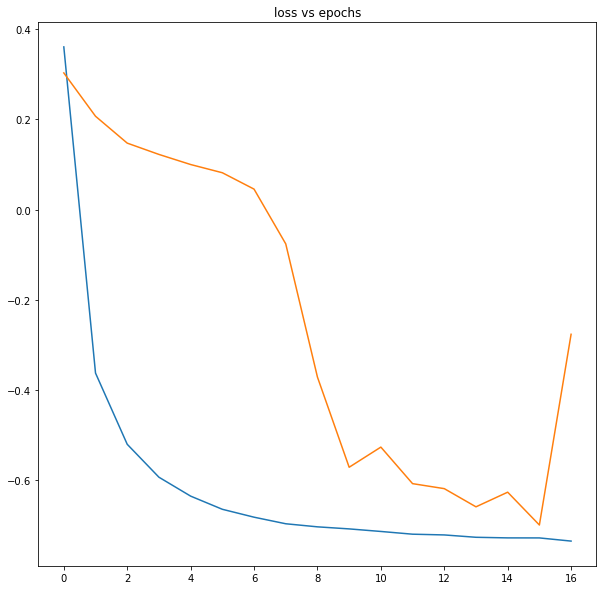

In [27]:
plt.figure(figsize=(10,10))
sns.lineplot(x=auto_encoder_s1_history.epoch, y=auto_encoder_s1_history.history['loss'], legend='full').set_title("loss vs epochs")
sns.lineplot(x=auto_encoder_s1_history.epoch, y=auto_encoder_s1_history.history['val_loss'], legend='full')

plt.savefig('a1_head_loss_vs_epochs.png')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


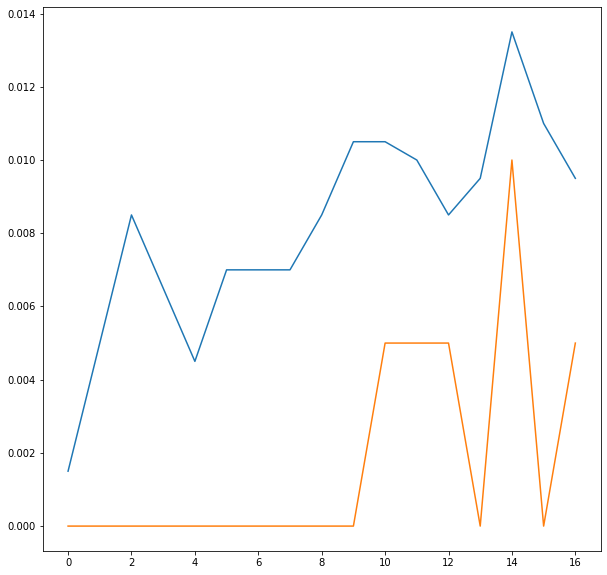

In [28]:
plt.figure(figsize=(10,10))
sns.lineplot(auto_encoder_s1_history.epoch, auto_encoder_s1_history.history['accuracy'])
sns.lineplot(auto_encoder_s1_history.epoch, auto_encoder_s1_history.history['val_accuracy'])

plt.savefig('a1_head_accuracy_vs_epochs.png')

In [31]:
del auto_x, auto_y
gc.collect()

auto_x = []
auto_y= []
n=20
for i in range(n):
    g_realistic = G2NetAutoEncoderDataGenerator(n=100)
    p_realistic = NumpyArrayPipeline(source=g_realistic,preprocessing_functions=pipe_funcs)
    auto_x.append(p_realistic())
    autoencoder_y0 = g_realistic.labels
    for i in range(len(autoencoder_y0)):
        autoencoder_y0[i] = reshape128(normalize(autoencoder_y0[i]))
    auto_y.append(np.array(autoencoder_y0, dtype=np.float16))
    del g_realistic, p_realistic, autoencoder_y0
    gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
auto_x = np.array(auto_x).reshape(n*100, 360, 128, 2).copy()
auto_y = np.array(auto_y).reshape(n*100, 360 * 128, ).copy()

gc.collect()
print(f"RAM: {cpu_stats()}")

RAM: memory GB:5.0


In [33]:
g_realistic = G2NetAutoEncoderDataGenerator(n=200)
p_realistic = NumpyArrayPipeline(source=g_realistic,preprocessing_functions=pipe_funcs)
auto_val_x = p_realistic()
autoencoder_y_val = g_realistic.labels

for i in range(len(autoencoder_y_val)):
    autoencoder_y_val[i] = reshape128(normalize(autoencoder_y_val[i]))
auto_val_y = np.array(autoencoder_y_val, dtype=np.float16).reshape(200, 360 * 128, ).copy()

  0%|          | 0/200 [00:00<?, ?it/s]

In [34]:
auto_val_x = np.array(auto_val_x)
del g_realistic, p_realistic, autoencoder_y_val

In [36]:
auto_encoder_s2 = create_autoencoder(auto_encoder_s1.input, auto_encoder_s1.output, loss="cosine_similarity", stack=True)
auto_encoder_s2_history = auto_encoder_s2.fit(x=[auto_x, auto_x], y=auto_y, validation_data=([auto_val_x, auto_val_x], auto_val_y), epochs=25, batch_size=32)
auto_encoder_s2.trainable = False
gc.collect()

Epoch 1/25
63/63 [==============================] - 9s 121ms/step - loss: 0.4393 - accuracy: 0.0050 - val_loss: 0.3590 - val_accuracy: 0.0000e+00
Epoch 2/25
63/63 [==============================] - 7s 105ms/step - loss: -0.3057 - accuracy: 0.0025 - val_loss: 0.2582 - val_accuracy: 0.0000e+00
Epoch 3/25
63/63 [==============================] - 7s 106ms/step - loss: -0.4656 - accuracy: 0.0045 - val_loss: 0.2141 - val_accuracy: 0.0000e+00
Epoch 4/25
63/63 [==============================] - 7s 106ms/step - loss: -0.5343 - accuracy: 0.0045 - val_loss: 0.1850 - val_accuracy: 0.0000e+00
Epoch 5/25
63/63 [==============================] - 7s 107ms/step - loss: -0.5682 - accuracy: 0.0070 - val_loss: 0.1693 - val_accuracy: 0.0000e+00
Epoch 6/25
63/63 [==============================] - 7s 105ms/step - loss: -0.5946 - accuracy: 0.0060 - val_loss: 0.1458 - val_accuracy: 0.0000e+00
Epoch 7/25
63/63 [==============================] - 7s 104ms/step - loss: -0.6085 - accuracy: 0.0080 - val_loss: 0.1030

1751

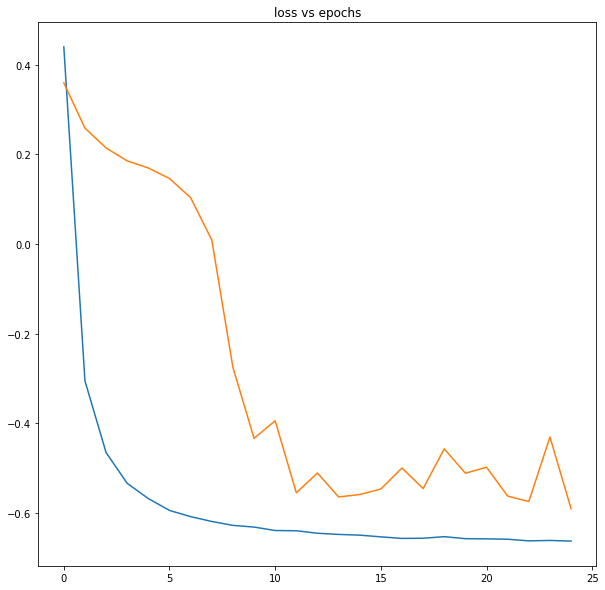

In [38]:
plt.figure(figsize=(10,10))
sns.lineplot(x=auto_encoder_s2_history.epoch, y=auto_encoder_s2_history.history['loss'], legend='full').set_title("loss vs epochs")
sns.lineplot(x=auto_encoder_s2_history.epoch, y=auto_encoder_s2_history.history['val_loss'], legend='full')

plt.savefig('a2_loss_vs_epochs.png')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


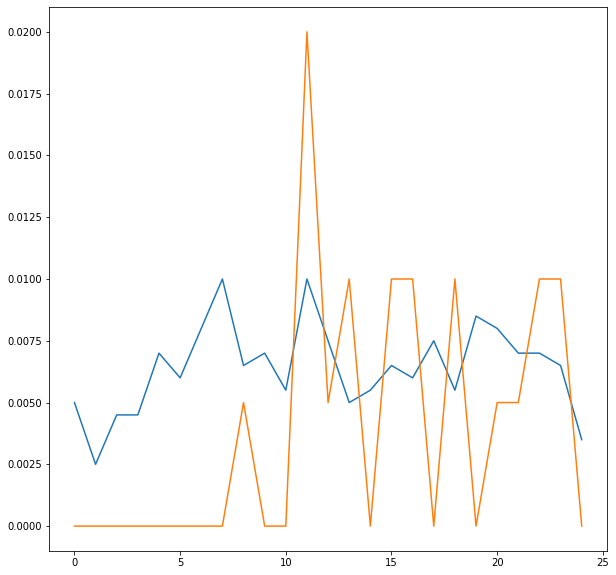

In [39]:
plt.figure(figsize=(10,10))
sns.lineplot(auto_encoder_s2_history.epoch, auto_encoder_s2_history.history['accuracy'])
sns.lineplot(auto_encoder_s2_history.epoch, auto_encoder_s2_history.history['val_accuracy'])

plt.savefig('a2_accuracy_vs_epochs.png')

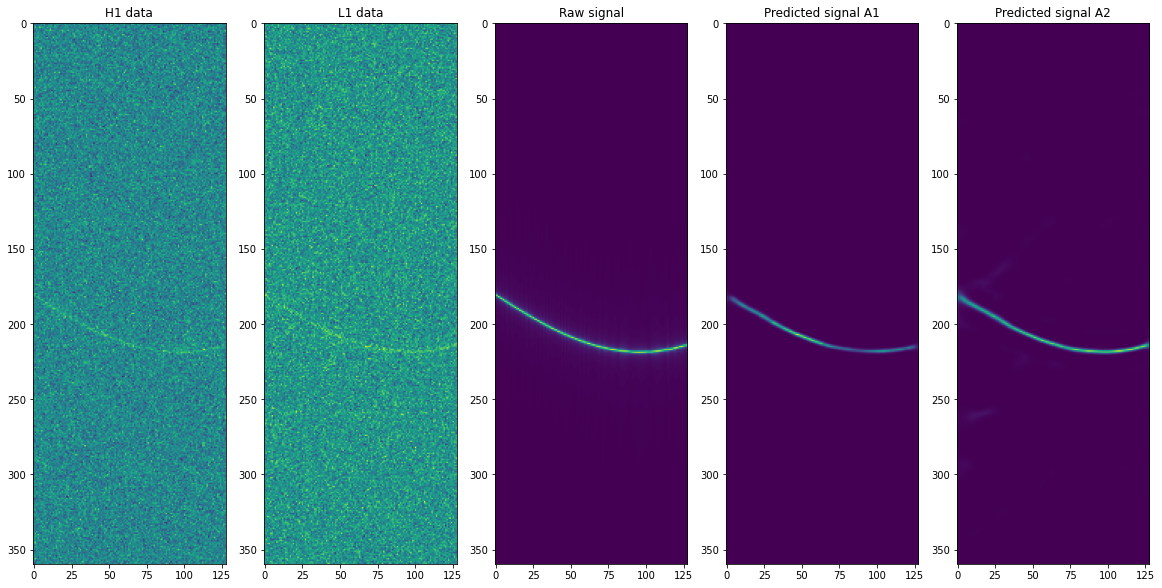

In [40]:
def display_auto_encoder_val(models: list, x_data, y_data, i):
    
    fig, ax = plt.subplots(ncols=3+len(models), figsize=(20, 10))
    ax[0].imshow(x_data[i,:,:, 0])
    ax[0].set_title('H1 data')
    ax[1].imshow(x_data[i,:,:, 1])
    ax[1].set_title('L1 data')
    ax[2].imshow(y_data[i].reshape(360,128))
    ax[2].set_title('Raw signal')
    ax[3].imshow(models[0].predict(x_data[[i], :, :]).reshape(360,128))
    ax[3].set_title('Predicted signal A1')
    ax[4].imshow(models[1].predict([x_data[[i], :, :], x_data[[i], :, :]]).reshape(360,128))
    ax[4].set_title('Predicted signal A2')
    
    plt.savefig(f'pred_img_{i}.jpeg')

display_auto_encoder_val([auto_encoder_s1, auto_encoder_s2], auto_val_x, auto_val_y, 10)

In [41]:
del auto_x, auto_y
gc.collect()

25323

In [42]:
def display_auto_encoder_test(models:list, x_data, y_data, i):
    
    print(f"target for this observation: {y_data[i]}")
    
    fig, ax = plt.subplots(ncols=4, figsize=(20, 10))
    ax[0].imshow(x_data[i,:,:, 0])
    ax[1].imshow(x_data[i,:,:, 1])
    ax[2].imshow(models[0].predict(x_data[[i], :, :]).reshape(360,128))
    ax[3].imshow(models[1].predict([x_data[[i], :, :],x_data[[i], :, :]]).reshape(360,128))

In [43]:
def nn_head(inp, base_out, input_shape=(360, 128, 1), loss='mse'):
    
    x = Reshape(input_shape)(base_out)
#     x = Dense(10, activation="relu", kernel_regularizer=regularizers.L2())(base_out)
    
#     x = Conv2D(16, (5, 5), activation='relu', padding='same',kernel_regularizer=regularizers.L2())(x)
#     x = MaxPooling2D((2, 2))(x)
    
#     x = Conv2D(8, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.L2())(x)
#     x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(16, (3, 3), activation='relu', padding="same",kernel_regularizer=regularizers.L2())(x)
    x = MaxPooling2D((3, 3))(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    
    out = Dense(1, activation="sigmoid")(x)
    
    model = Model(inp, out)
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model

In [44]:
print('Fetching generated data...'); ti = time()
g_generated = G2NetGeneratedDataGenerator()
p_generated = NumpyArrayPipeline(source=g_generated, preprocessing_functions=pipe_funcs)
generated_x = p_generated()
generated_x = np.array(generated_x)
generated_y = np.array(g_generated.labels["0"])
generated_x_tr, generated_x_te, generated_y_tr, generated_y_te = train_test_split(generated_x,generated_y,train_size=0.9,random_state=42,stratify=generated_y)
del generated_x, generated_y
gc.collect()
print(f'Done: {round(time() - ti)} seconds')
print(f'RAM: {cpu_stats()}')

Fetching generated data...


  0%|          | 0/5000 [00:00<?, ?it/s]

Done: 107 seconds
RAM: memory GB:6.5


In [45]:
print('Fetching compitition data...'); ti = time()
g_compitition = G2NetCompetitionDataGenerator()
p_compitition = NumpyArrayPipeline(source=g_compitition, preprocessing_functions=pipe_funcs)
compitition_x = p_compitition()
compitition_x = np.array(compitition_x)
compitition_y = np.array(g_compitition.labels())
compitition_x_tr, compitition_x_te, compitition_y_tr, compitition_y_te = train_test_split(compitition_x,compitition_y,train_size=0.9,random_state=42,stratify=compitition_y)
del compitition_x, compitition_y
gc.collect()
print(f'Done: {round(time() - ti)} seconds')
print(f'RAM: {cpu_stats()}')

Fetching compitition data...


  0%|          | 0/600 [00:00<?, ?it/s]

Done: 13 seconds
RAM: memory GB:6.71


In [46]:
print('Fetching realistic data...'); ti = time()
g_realistic = G2NetRealisticDataGenerator()
p_realistic = NumpyArrayPipeline(source=g_realistic, preprocessing_functions=pipe_funcs)
realistic_x = p_realistic()
realistic_x = np.array(realistic_x)
realistic_y = np.array(g_realistic.labels)
realistic_x_tr, realistic_x_te, realistic_y_tr, realistic_y_te = train_test_split(realistic_x,realistic_y,train_size=0.9,random_state=42,stratify=realistic_y)
del realistic_x, realistic_y
gc.collect()
print(f'Done: {round(time() - ti)} seconds')
print(f'RAM: {cpu_stats()}')

Fetching realistic data...


  0%|          | 0/1497 [00:00<?, ?it/s]

Done: 341 seconds
RAM: memory GB:7.22


In [47]:
head_x_tr = np.concatenate([realistic_x_tr, compitition_x_tr, generated_x_tr])
head_x_te = np.concatenate([realistic_x_te, compitition_x_te, generated_x_te])

head_y_tr = np.concatenate([realistic_y_tr, compitition_y_tr, generated_y_tr])
head_y_te = np.concatenate([realistic_y_te, compitition_y_te, generated_y_te])

del realistic_x_tr, realistic_x_te, realistic_y_tr, realistic_y_te
del compitition_x_tr, compitition_x_te, compitition_y_tr, compitition_y_te
del generated_x_tr, generated_x_te, generated_y_tr, generated_y_te
gc.collect()

23

target for this observation: 0


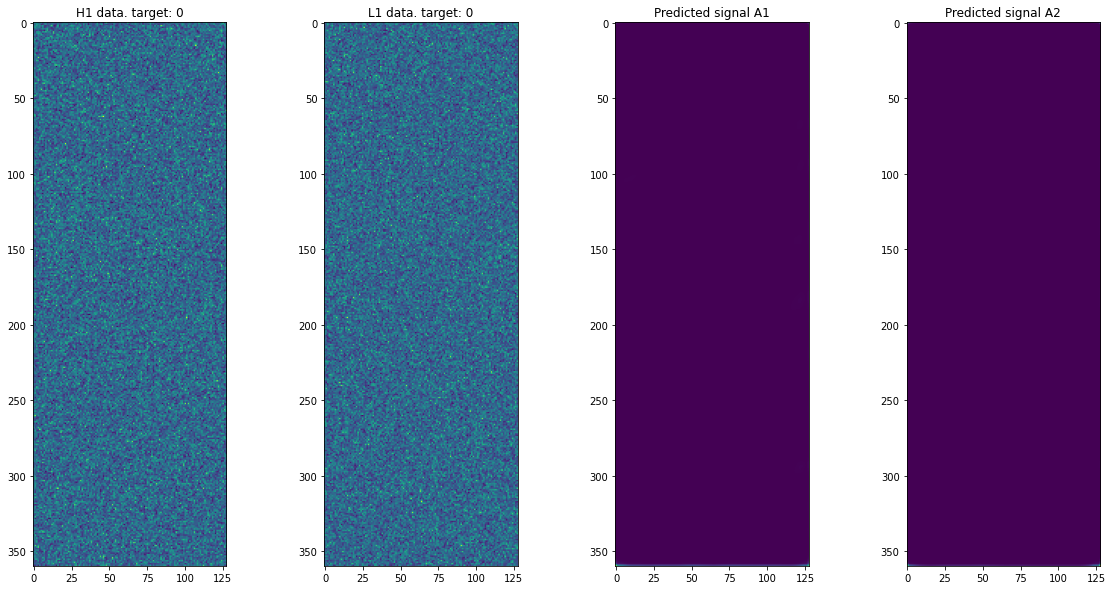

In [48]:
def display_auto_encoder_test(models:list, x_data, y_data, i):
    
    print(f"target for this observation: {y_data[i]}")
    
    fig, ax = plt.subplots(ncols=4, figsize=(20, 10))
    ax[0].imshow(x_data[i,:,:, 0])
    ax[0].set_title(f'H1 data. target: {y_data[i]}')
    ax[1].imshow(x_data[i,:,:, 1])
    ax[1].set_title(f'L1 data. target: {y_data[i]}')
    ax[2].imshow(models[0].predict(x_data[[i], :, :]).reshape(360,128))
    ax[2].set_title('Predicted signal A1')
    ax[3].imshow(models[1].predict([x_data[[i], :, :], x_data[[i], :, :]]).reshape(360,128))
    ax[3].set_title('Predicted signal A2')
    
    plt.savefig(f'a2_test_pred_{i}')
    
display_auto_encoder_test([auto_encoder_s1, auto_encoder_s2], head_x_te, head_y_te, 405)

In [49]:
conv_head = nn_head(auto_encoder_s1.input, auto_encoder_s1.output)
conv_head.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 360, 128, 2)]     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 360, 128, 64)      1216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 180, 64, 64)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 180, 64, 64)       256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 64, 32)       18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 90, 32, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 90, 32, 32)        128 

In [50]:
conv_head_hist = conv_head.fit(head_x_tr, 
                               head_y_tr, 
                               validation_split=0.9,
                               epochs=20, 
                               batch_size=32)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.5172

2023-01-16 21:44:56.685464: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2118942720 exceeds 10% of free system memory.
2023-01-16 21:44:59.268668: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2118942720 exceeds 10% of free system memory.


20/20 [==============================] - 16s 777ms/step - loss: 0.3478 - accuracy: 0.5172 - val_loss: 0.3459 - val_accuracy: 0.4831
Epoch 2/20
20/20 [==============================] - 6s 294ms/step - loss: 0.3423 - accuracy: 0.5313 - val_loss: 0.3441 - val_accuracy: 0.4831
Epoch 3/20
20/20 [==============================] - 6s 290ms/step - loss: 0.3393 - accuracy: 0.5313 - val_loss: 0.3389 - val_accuracy: 0.4831
Epoch 4/20
20/20 [==============================] - 6s 291ms/step - loss: 0.3371 - accuracy: 0.5313 - val_loss: 0.3375 - val_accuracy: 0.4831
Epoch 5/20
20/20 [==============================] - 6s 295ms/step - loss: 0.3355 - accuracy: 0.5157 - val_loss: 0.3367 - val_accuracy: 0.4831
Epoch 6/20
20/20 [==============================] - 6s 292ms/step - loss: 0.3341 - accuracy: 0.5313 - val_loss: 0.3337 - val_accuracy: 0.4831
Epoch 7/20
20/20 [==============================] - 6s 290ms/step - loss: 0.3329 - accuracy: 0.5313 - val_loss: 0.3346 - val_accuracy: 0.4831
Epoch 8/20
20/20

In [51]:
yhat = conv_head.predict(head_x_te)
confusion_matrix(head_y_te, np.round(yhat))

array([[347,   0],
       [363,   0]])

In [52]:
f1_score(head_y_te, np.round(yhat), average="weighted")

0.32088957586579075

In [53]:
roc_auc_score(head_y_te, np.round(yhat))

0.5

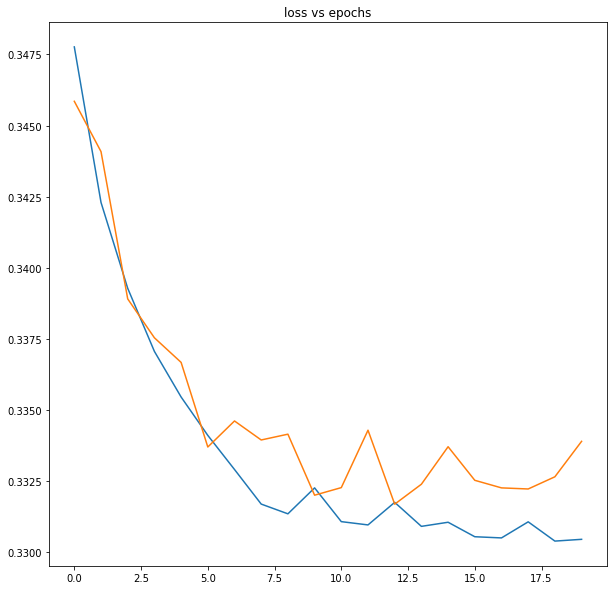

In [54]:
plt.figure(figsize=(10,10))
sns.lineplot(x=conv_head_hist.epoch, y=conv_head_hist.history['loss'], legend='full').set_title("loss vs epochs")
sns.lineplot(x=conv_head_hist.epoch, y=conv_head_hist.history['val_loss'], legend='full')

plt.savefig('a1_head_loss_vs_epochs.png')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


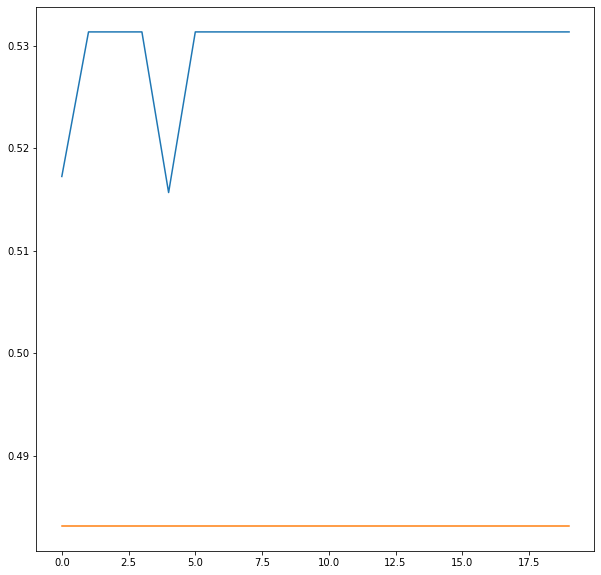

In [55]:
plt.figure(figsize=(10,10))
sns.lineplot(conv_head_hist.epoch, conv_head_hist.history['accuracy'])
sns.lineplot(conv_head_hist.epoch, conv_head_hist.history['val_accuracy'])

plt.savefig('a1_head_accuracy_vs_epochs.png')